In [1]:
######################################################################################################
## Etapa 0: Importando as bibliotecas necessárias
######################################################################################################
import os
import time

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image, display_image
from src.modules.detection import Detection, plot_detection
from src.modules.canny import Canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path
from src.modules.compute_splines import ComputeSplines, plot_splines

1 (2, 3)
2 (3, 4)


[(2, 3), (3, 4)]

In [ ]:
def process_image(file_path):
    try:
        start_step1 = time.time()
        print("Etapa 1: Leitura da imagem")
        img = Image(file_path)
        img.reading_image()
        end_step1 = time.time()


        # Etapa 2: Detecção de características
        print("Etapa 2: Detecção de características")
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        end_step2 = time.time()


        # Etapa 3: Detecção de bordas
        print("Etapa 3: Detecção de bordas")
        canny = Canny(detection.mouth, detection.nose, detection.left_eye, detection.right_eye)
        canny.compute_all_edges()
        end_step3 = time.time()


        # Etapa 4: Criação das matrizes de adjacência
        print("Etapa 4: Criação das matrizes de adjacência")
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()
        end_step4 = time.time()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        print("Etapa 5: Cálculo de componentes conectados para cada matriz")
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()
        end_step5 = time.time()
        # Etapa 6: Cálculo da árvore geradora mínima
        print("Etapa 6: Cálculo da árvore geradora mínima")
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()
        end_step6 = time.time()
        # Etapa 7: Construção da árvore e poda
        print("Etapa 7: Construção da árvore e poda")
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        end_step7 = time.time()
        # Etapa 8: Splines
        print("Etapa 8: Splines")
        splines = ComputeSplines(tree.new_longest_path_nose, tree.new_longest_path_mouth, tree.new_longest_path_left_eye, tree.new_longest_path_right_eye,
                                 mst.nodes_nose, mst.nodes_mouth, mst.nodes_left_eye, mst.nodes_right_eye,
                                 canny.nose_dict, canny.mouth_dict, canny.left_eye_dict, canny.right_eye_dict,
                                 mst.idx_nose, mst.idx_mouth, mst.idx_left_eye, mst.idx_right_eye)
        splines.compute_all_splines()
        end_step8 = time.time()

        

        print(f"Processado: {file_path}")
        print(f"Tempo1 {end_step1 - start_step1}\nTempo2 {end_step2 - end_step1}\nTempo3 {end_step3 - end_step2}\nTempo4 {end_step4 - end_step3}\nTempo5 {end_step5 - end_step4}\nTempo6 {end_step6 - end_step5}\nTempo7 {end_step7 - end_step6}\nTempo8 {end_step8 - end_step7}")
        return img, detection, canny, adjacency_matrix, components_results, mst, tree, splines

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './image'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))



In [12]:
results[0][1].face

array([[ 40,  39,  42, ..., 199, 199, 199],
       [ 40,  40,  42, ..., 199, 199, 199],
       [ 41,  41,  42, ..., 199, 199, 199],
       ...,
       [ 44,  44,  45, ..., 183, 183, 183],
       [ 44,  44,  45, ..., 183, 183, 183],
       [ 44,  44,  45, ..., 183, 183, 183]], dtype=uint8)

In [32]:
from retinaface import RetinaFace

In [33]:
model = RetinaFace.build_model()
model

In [34]:
resp = RetinaFace.detect_faces("./image/pedro.jpg", model = model)

In [26]:
[int(x) for x in resp["face_1"]["landmarks"]["left_eye"]]

[261, 195]

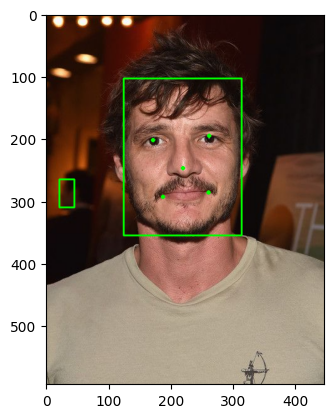

In [29]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('./image/pedro.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.rectangle(image, (124, 103), (313, 355), (0, 255, 0), 2)
cv2.rectangle(image, (21, 265), (45, 310), (0, 255, 0), 2)

#plotar um ponto na imagem
cv2.circle(image, tuple([int(x) for x in resp["face_1"]["landmarks"]["left_eye"]]), 2, (0, 255, 0), 2)
cv2.circle(image, tuple([int(x) for x in resp["face_1"]["landmarks"]["right_eye"]]), 2, (0, 255, 0), 2)
cv2.circle(image, tuple([int(x) for x in resp["face_1"]["landmarks"]["nose"]]), 2, (0, 255, 0), 2)
cv2.circle(image, tuple([int(x) for x in resp["face_1"]["landmarks"]["mouth_right"]]), 2, (0, 255, 0), 2)
cv2.circle(image, tuple([int(x) for x in resp["face_1"]["landmarks"]["mouth_left"]]), 2, (0, 255, 0), 2)

plt.imshow(image)
plt.show()

In [ ]:
import cv2

imagem = cv2.imread("./image/pedro.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
imagem.imshow()

In [6]:
resp

NameError: name 'resp' is not defined

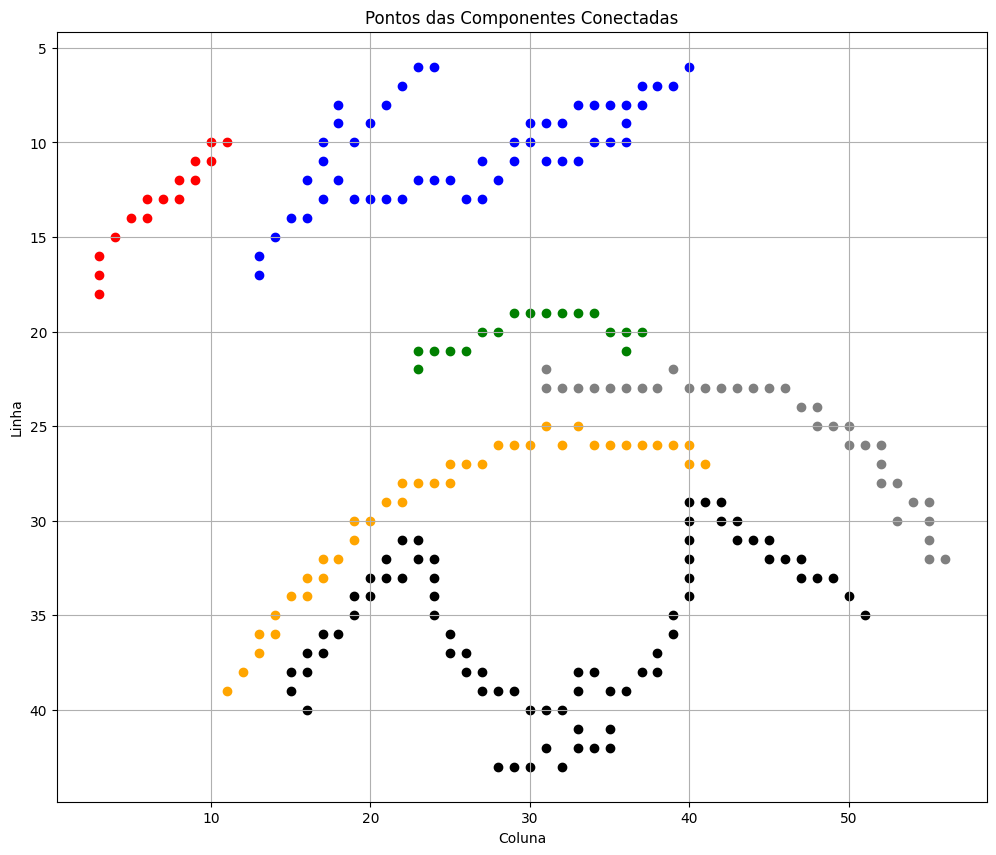

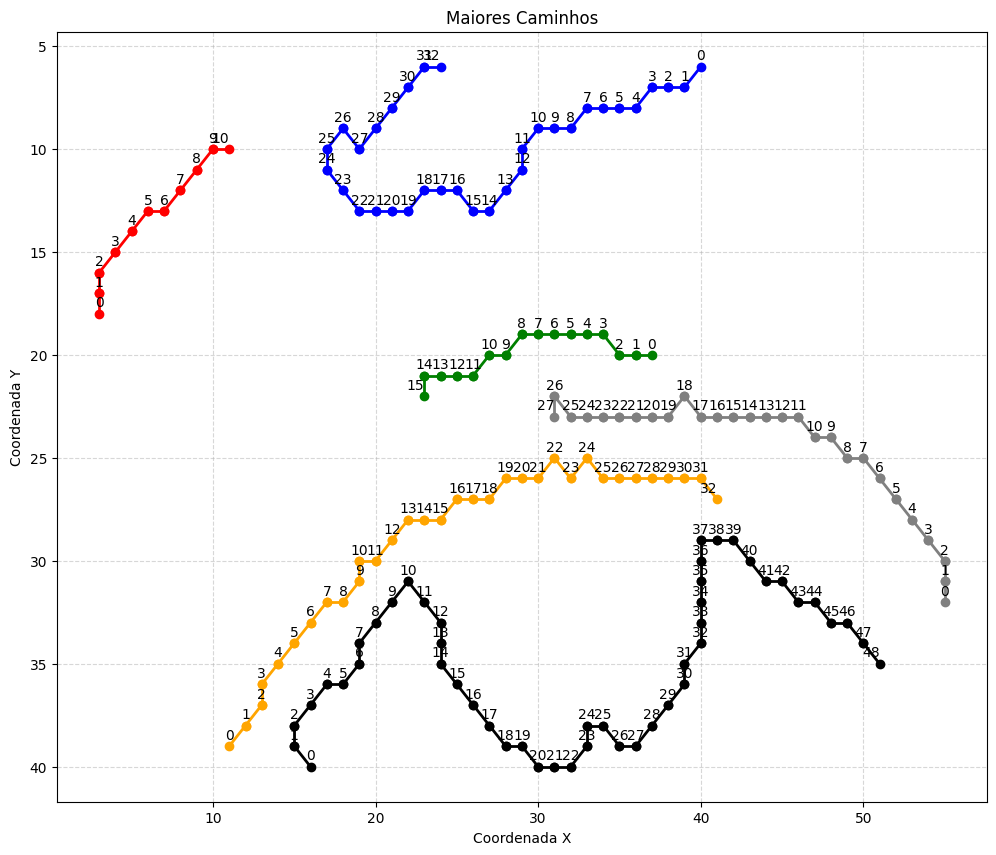

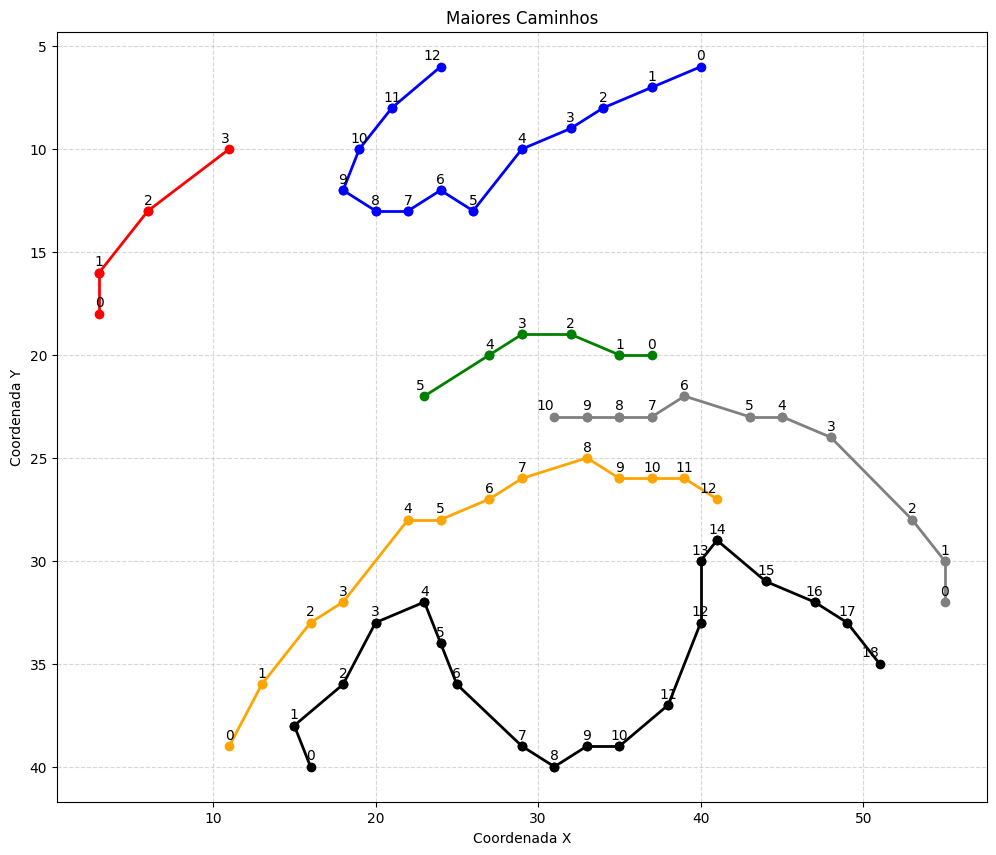

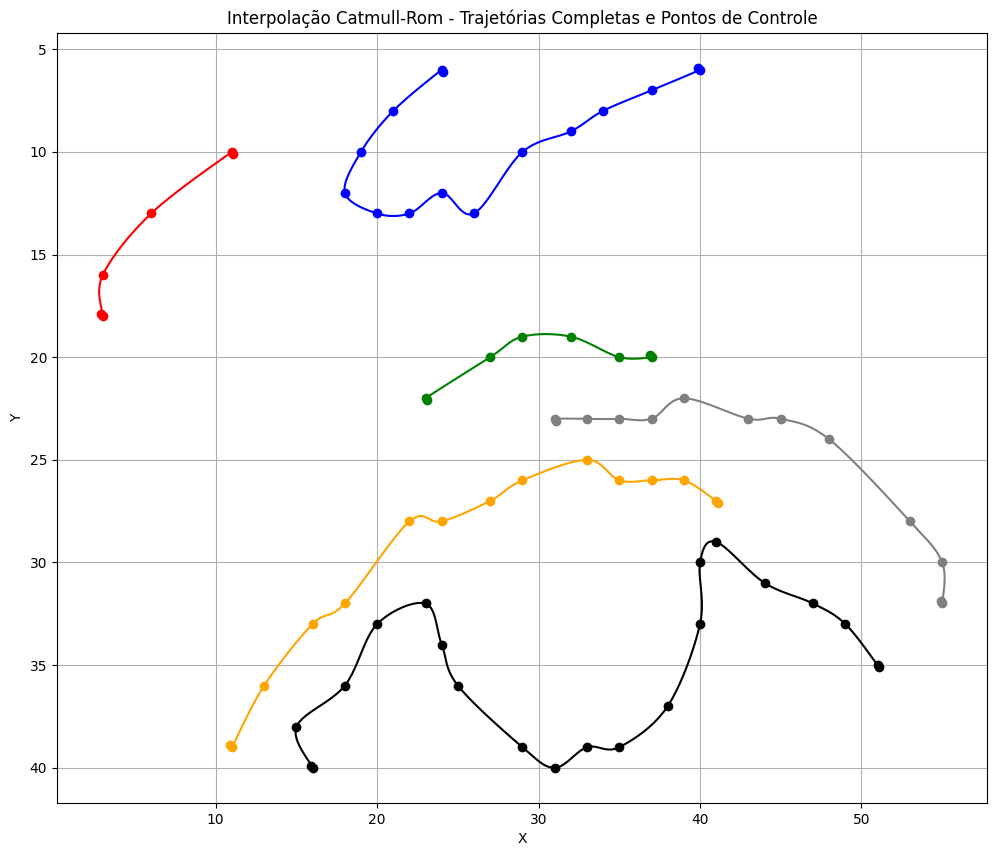

In [3]:
highlight_components(results[0][2].left_eye_dict, results[0][4].dic_main_left_eye_cc)
plot_logest_path(results[0][2].left_eye_dict, results[0][6].longest_path_left_eye, results[0][5].nodes_left_eye)
plot_logest_path(results[0][2].left_eye_dict, results[0][6].new_longest_path_left_eye, results[0][5].nodes_left_eye)
plot_splines(results[0][7].all_X_left_eye, results[0][7].all_Y_left_eye, results[0][7].all_control_x_left_eye, results[0][7].all_control_y_left_eye)


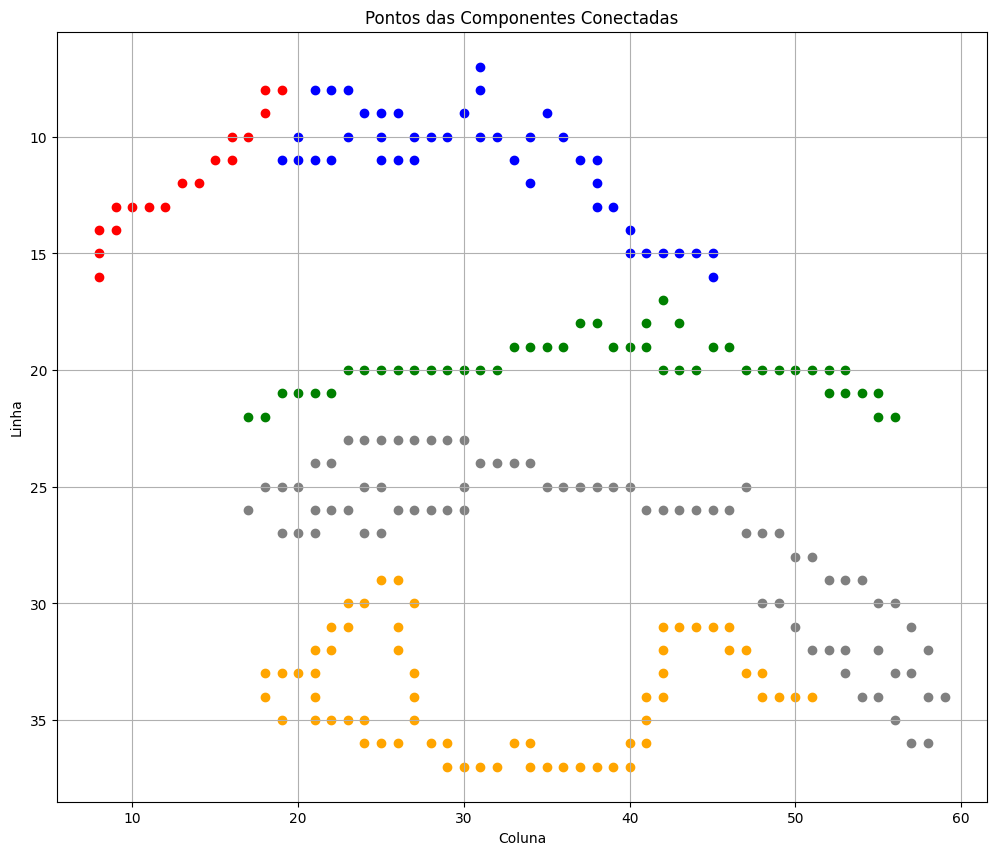

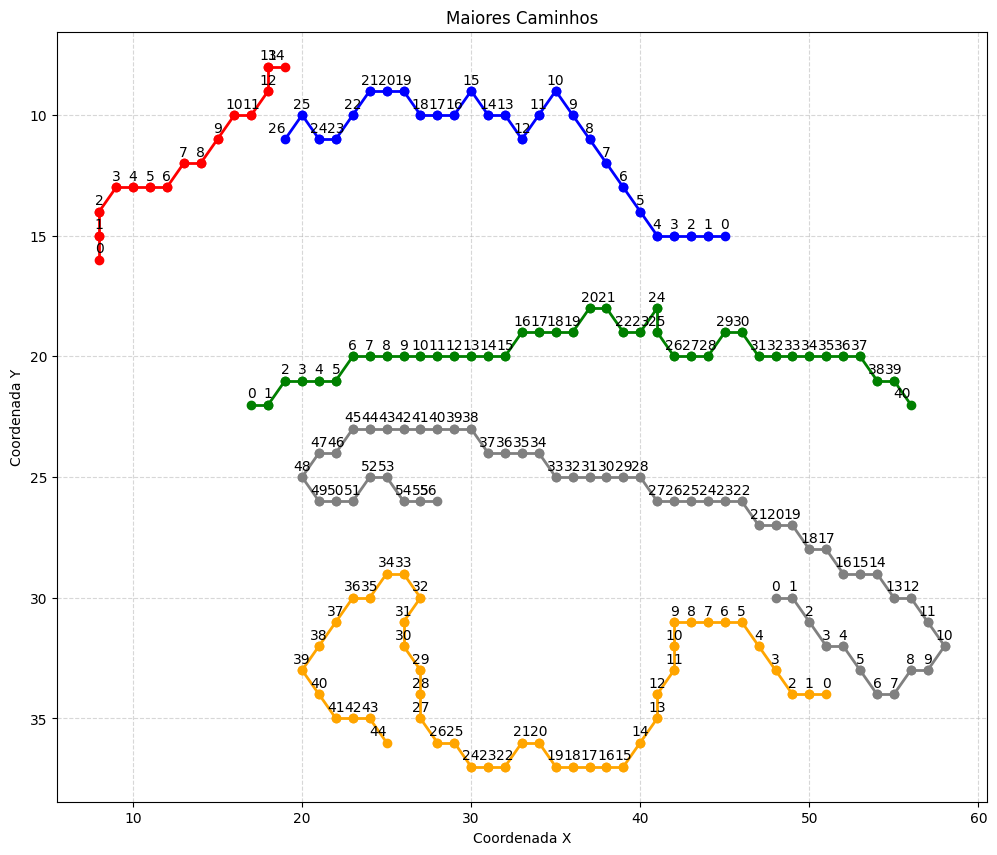

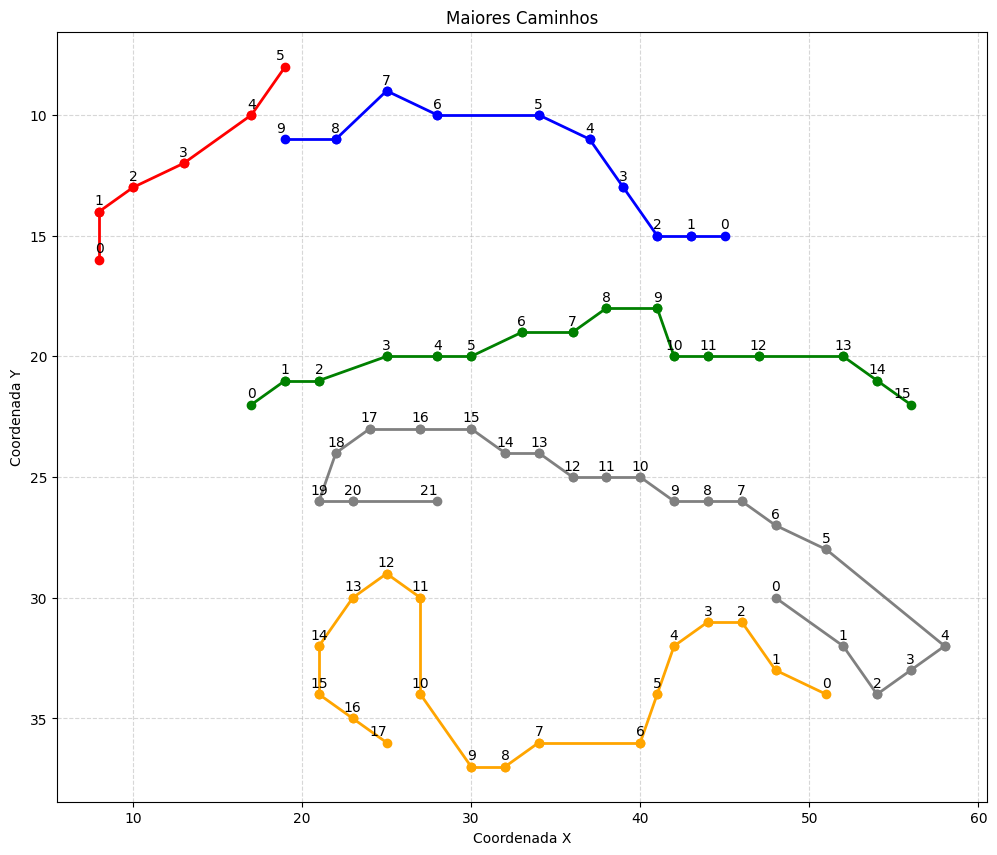

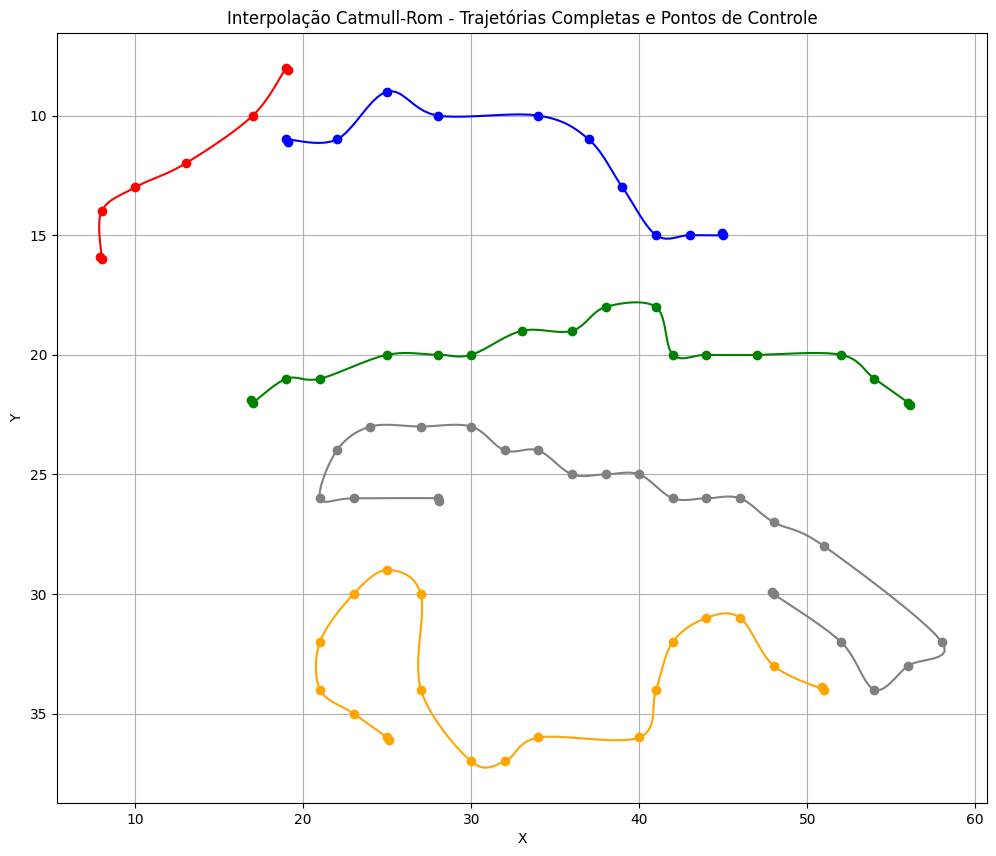

In [4]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye)
plot_splines(results[0][7].all_X_right_eye, results[0][7].all_Y_right_eye, results[0][7].all_control_x_right_eye, results[0][7].all_control_y_right_eye)


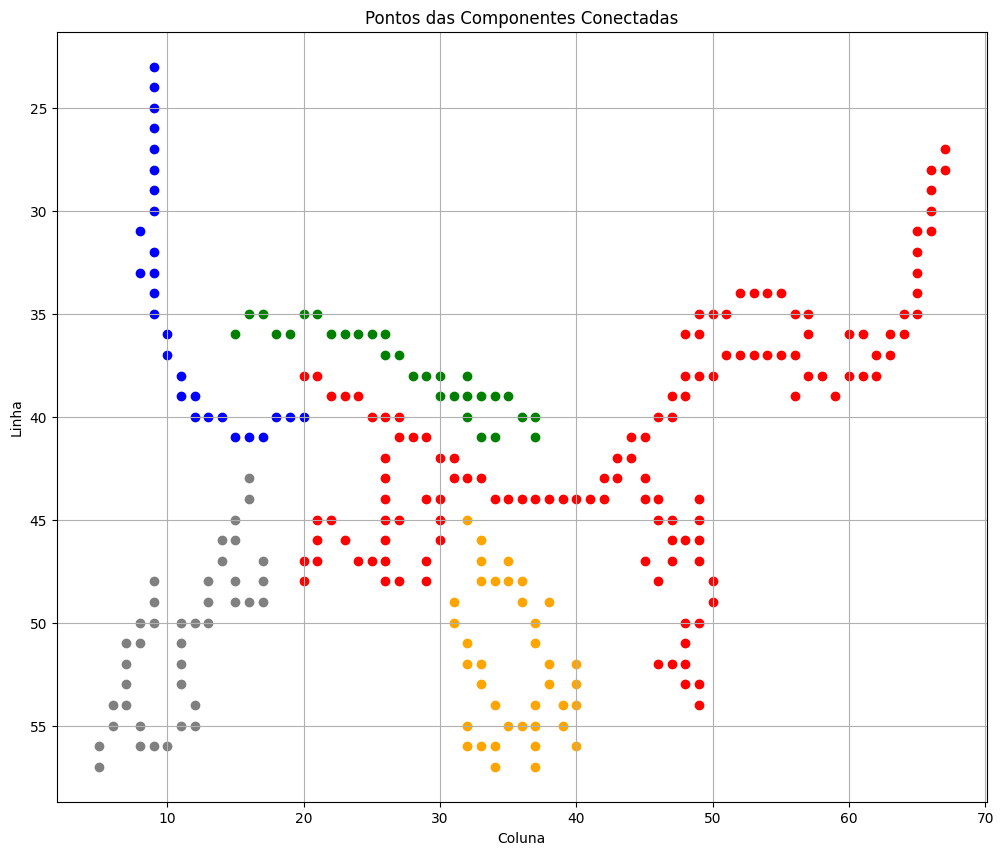

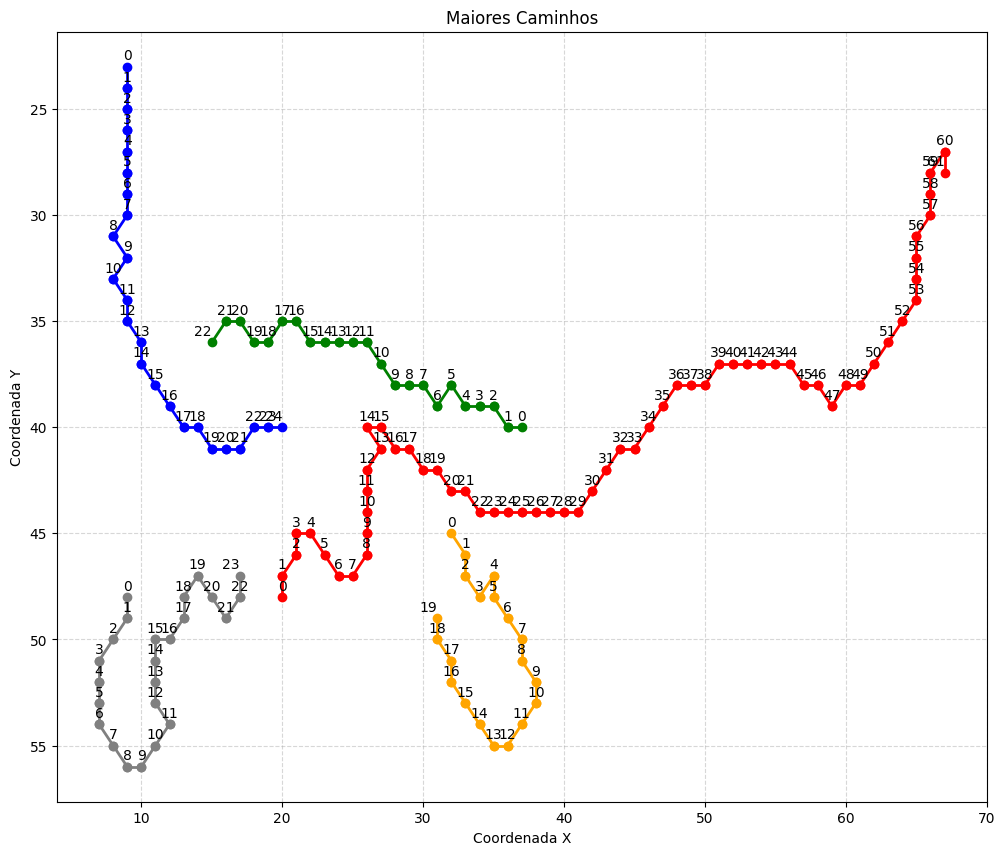

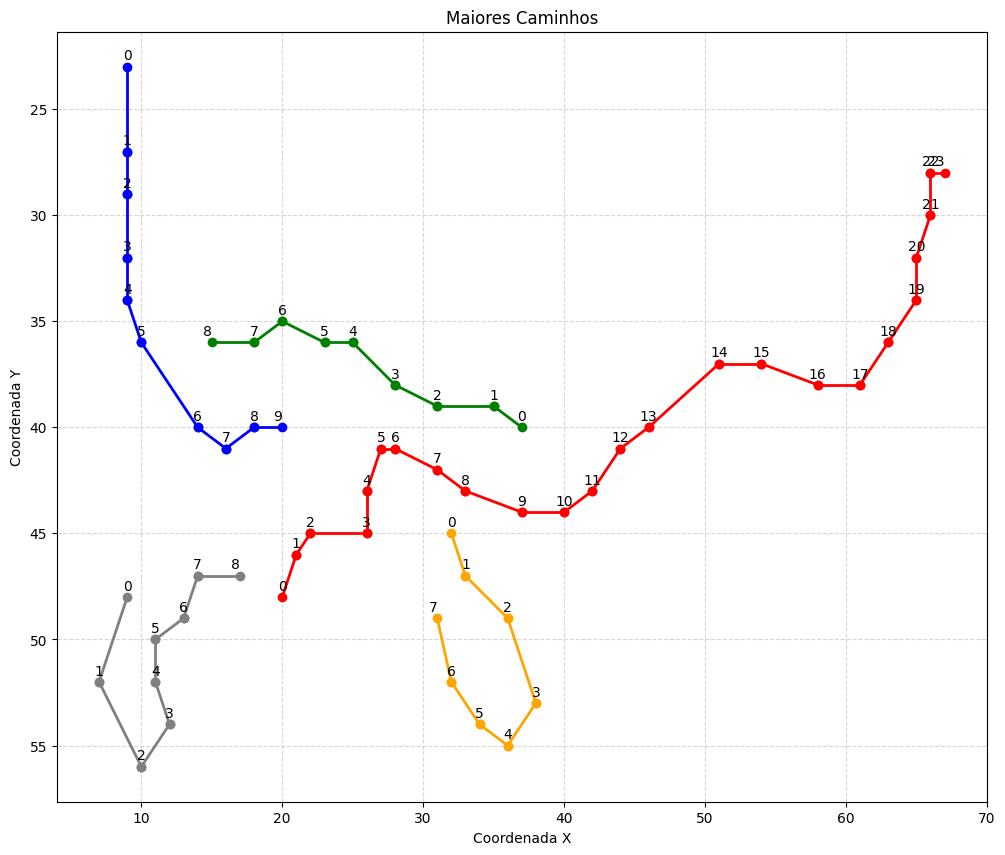

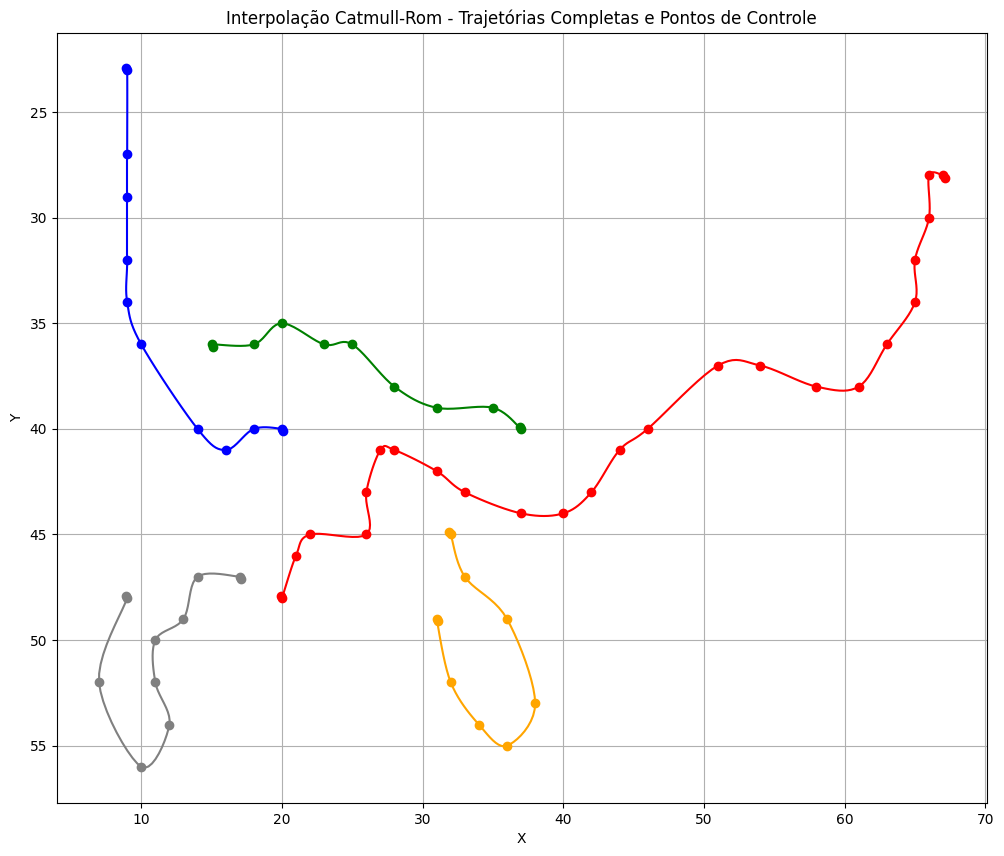

In [5]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose)
plot_splines(results[0][7].all_X_nose, results[0][7].all_Y_nose, results[0][7].all_control_x_nose, results[0][7].all_control_y_nose)


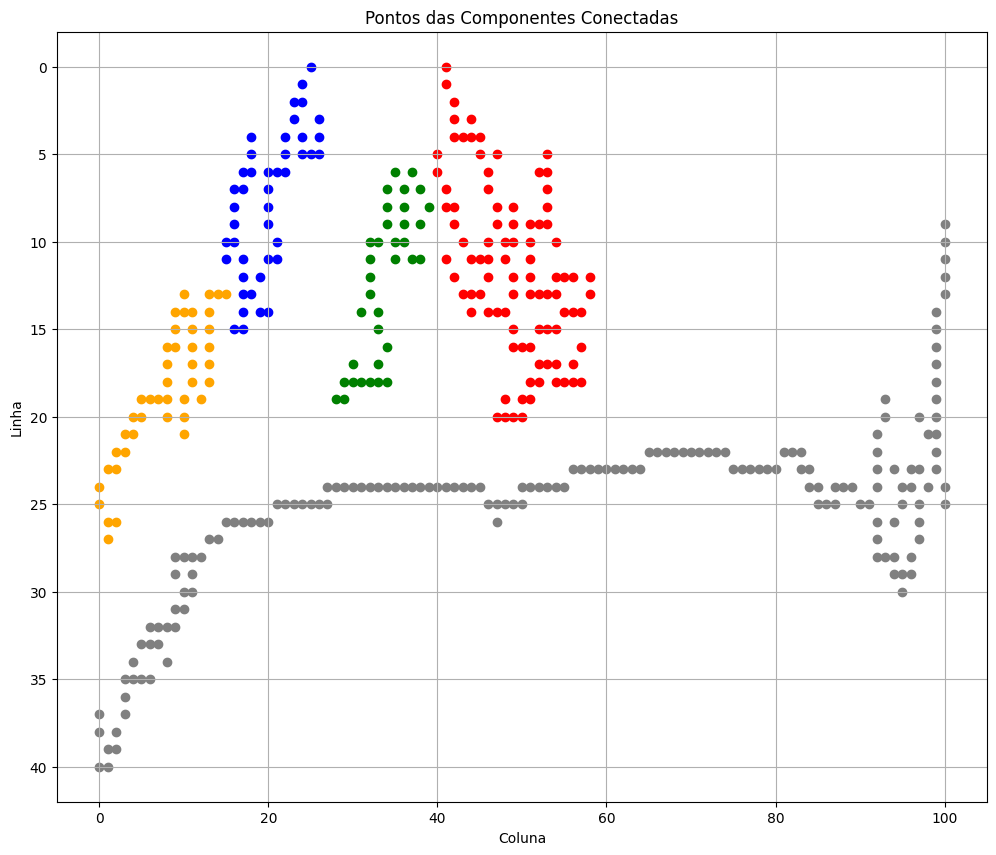

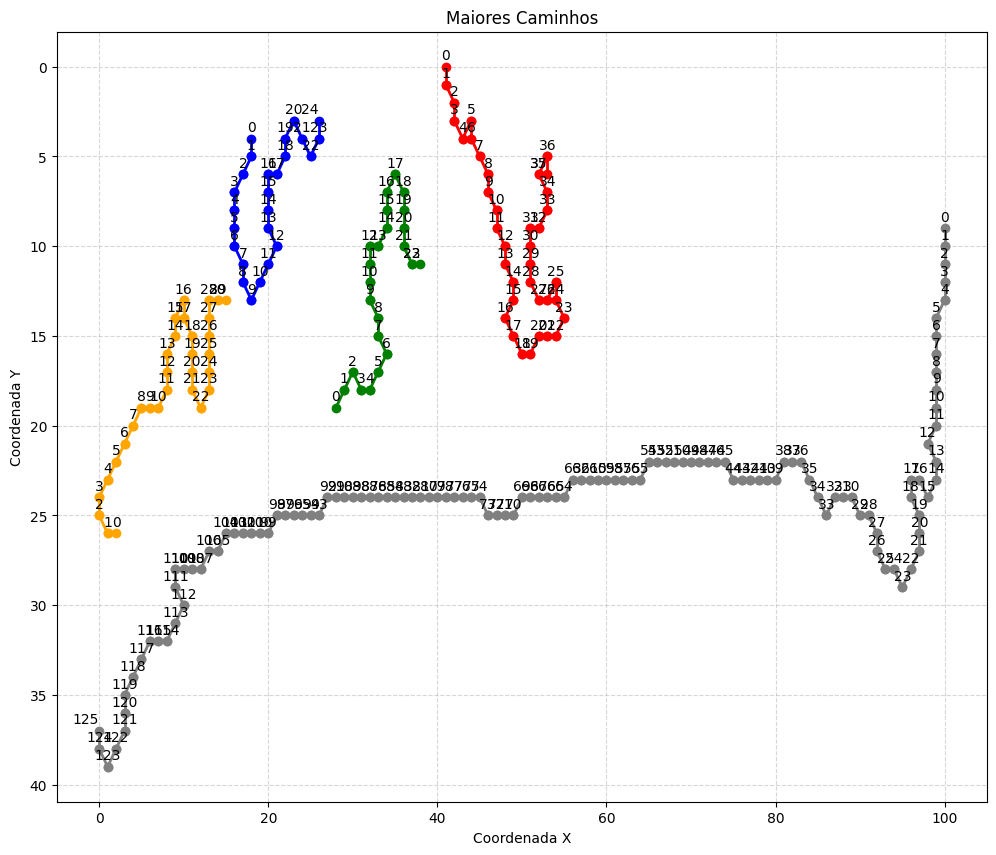

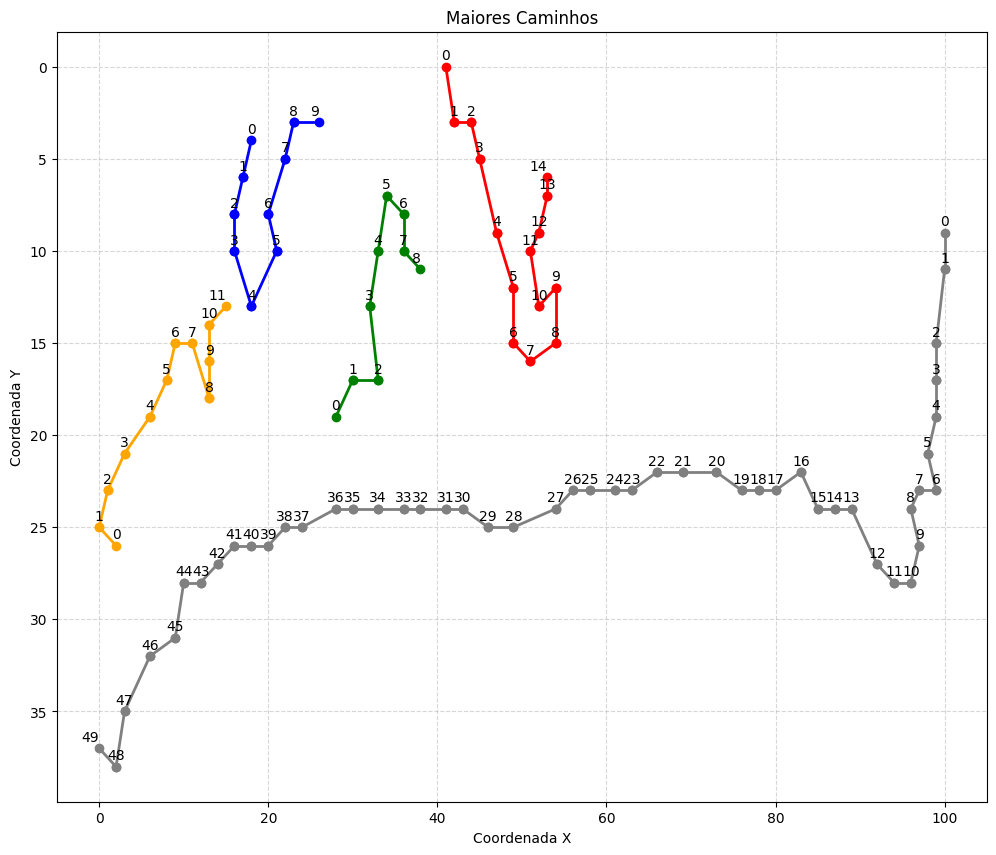

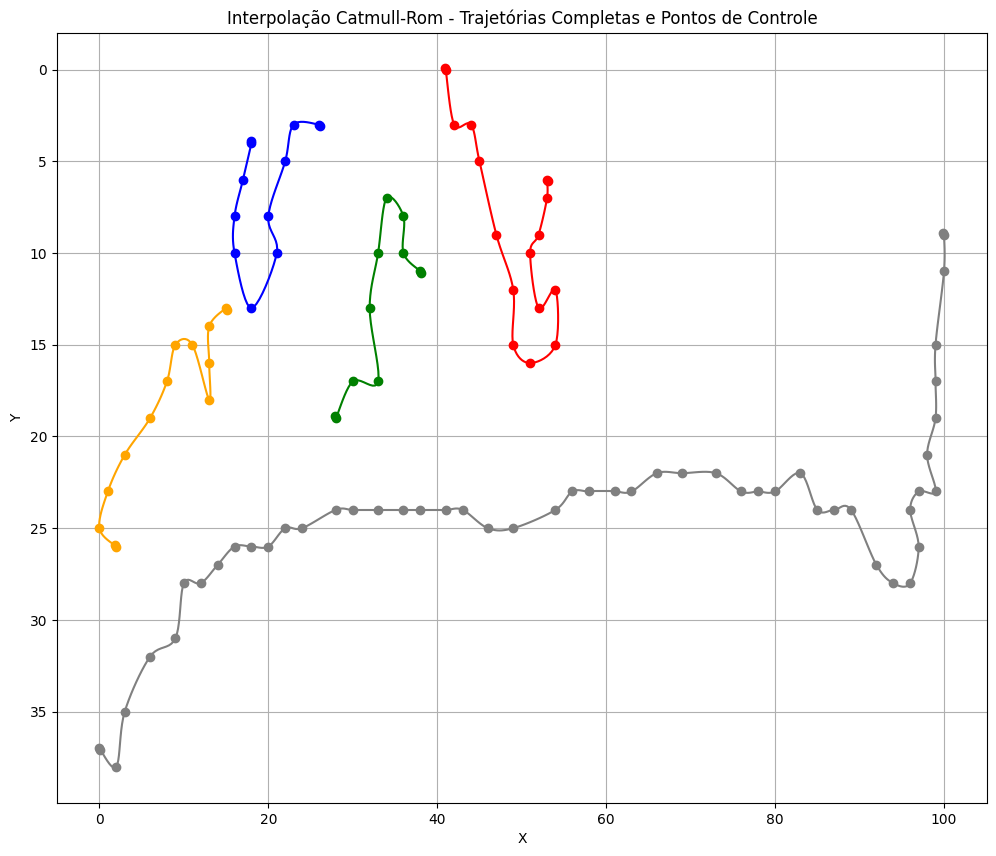

In [6]:

highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc)
plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth)
plot_logest_path(results[0][2].mouth_dict, results[0][6].new_longest_path_mouth, results[0][5].nodes_mouth)
plot_splines(results[0][7].all_X_mouth, results[0][7].all_Y_mouth, results[0][7].all_control_x_mouth, results[0][7].all_control_y_mouth)